In [13]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-


# Machine Learning

## Session 14c

### OpenVINO Text Identification

<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [14]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from openvino.runtime import Core
from pathlib import Path
import sys

sys.path.append("./utils")
from notebook_utils import download_file

In [15]:
# Some Basic Parameters for housekeeping

# set location of input files:
inpDir = os.path.join('..', '..', 'input')

# set location of inputs for this module
moduleDir = 'machine_learning'

# set location of inputs for this module
subDir = 'vino'

# set location of output files
outDir = os.path.join('..', 'output')

# set location of model files
modelDir = os.path.join('..', 'models')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 9),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.brg
plt.rcParams.update(params)
plt.set_cmap(CMAP)

plt.style.use('bmh')

TEST_SIZE = 0.2

<Figure size 1500x900 with 0 Axes>

In [16]:
base_model_dir = Path("./model").expanduser() # expand the path as per the os and environment

model_name = "horizontal-text-detection-0001"
model_xml_name = f'{model_name}.xml'
model_bin_name = f'{model_name}.bin'

model_xml_path = base_model_dir / model_xml_name
model_bin_path = base_model_dir / model_bin_name

if not model_xml_path.exists():
    model_xml_url = "https://storage.openvinotoolkit.org/repositories/open_model_zoo/2022.3/models_bin/1/horizontal-text-detection-0001/FP32/horizontal-text-detection-0001.xml"
    model_bin_url = "https://storage.openvinotoolkit.org/repositories/open_model_zoo/2022.3/models_bin/1/horizontal-text-detection-0001/FP32/horizontal-text-detection-0001.bin"

    download_file(model_xml_url, model_xml_name, base_model_dir)
    download_file(model_bin_url, model_bin_name, base_model_dir)
else:
    print(f'{model_name} already downloaded to {base_model_dir}')

horizontal-text-detection-0001 already downloaded to model


OpenVINO enables you to optimize a deep learning model from almost any framework and deploy it with best-in-class performance on a range of Intel processors and other hardware platforms.

A typical workflow with OpenVINO is shown below.

<img src='../../images/openVINO_fig2.png' width='600' alt="OpenVINO Workflow"/>

OpenVINO Runtime automatically optimizes deep learning pipelines using aggressive graph fusion, memory reuse, load balancing, and inferencing parallelism across CPU, GPU, VPU, and more. You can integrate and offload to accelerators additional operations for pre- and post-processing to reduce end-to-end latency and improve throughput.

Boost your model’s speed even further with quantization and other state-of-the-art compression techniques available in OpenVINO’s Post-Training Optimization Tool and Neural Network Compression Framework. These techniques also reduce your model size and memory requirements, allowing it to be deployed on resource-constrained edge hardware.



### Local Inferencing & Model Serving

You can either link directly with OpenVINO Runtime to run inference locally or use OpenVINO Model Serving to serve model inference from separate server or within Kubernetes environment

### Improved Application Portability

Write an application once, deploy it anywhere, achieving maximum performance from hardware. Automatic device discovery allows for superior deployment flexibility. OpenVINO Runtime supports Linux, Windows and MacOS and provides Python, C++ and C API. Use your preferred language and OS.

### Minimal External Dependencies

Designed with minimal external dependencies reduces the application footprint, simplifying installation and dependency management. Popular package managers enable application dependencies to be easily installed and upgraded. Custom compilation for your specific model(s) further reduces final binary size.



### Enhanced App Start-Up Time

In applications where fast start-up is required, OpenVINO significantly reduces first-inference latency by using the CPU for initial inference and then switching to GPU or VPU once the model has been compiled and loaded to memory. Compiled models are cached to further improving start-up time.


In [17]:
ie = Core()

model = ie.read_model(model=model_xml_path)
compiled_model = ie.compile_model(model=model, device_name="CPU")

input_layer_ir = compiled_model.input(0)
output_layer_ir = compiled_model.output("boxes")


## Load an Image

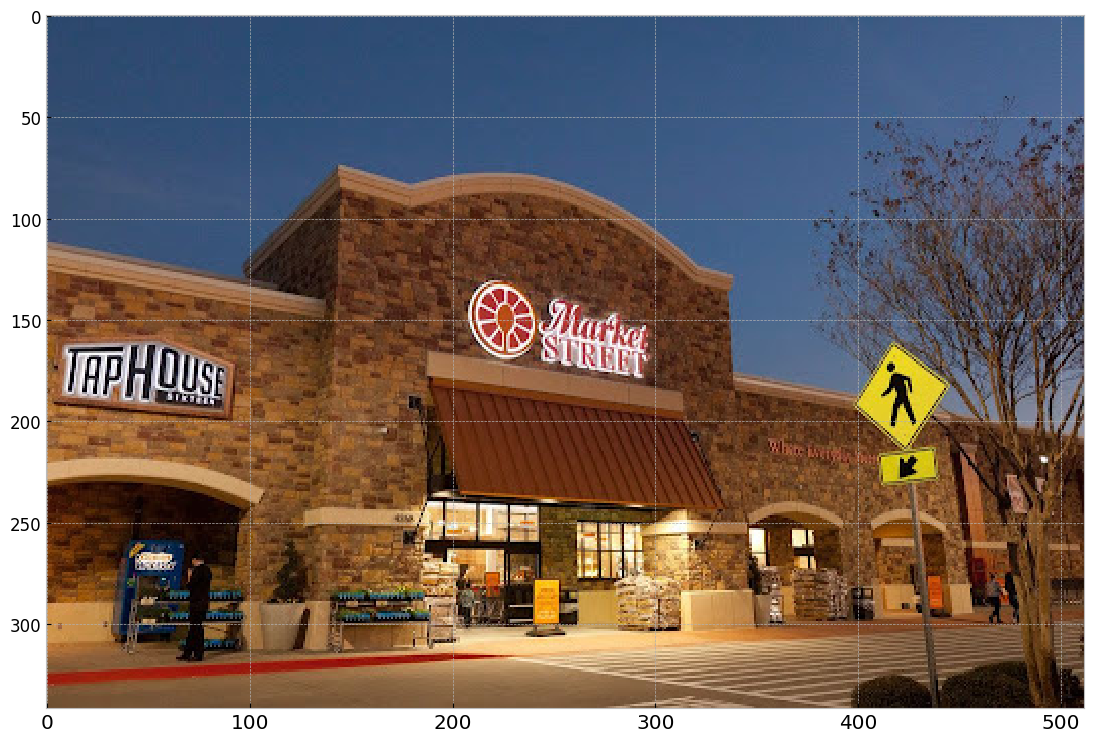

In [18]:
# Text detection models expect an image in BGR format.
#image = cv2.imread(filename=os.path.join(inpDir,'basic_operations/IMG_1295.JPG'))
image = cv2.imread(filename=os.path.join(inpDir,'basic_operations/market.jpg'))

# N,C,H,W = batch size, number of channels, height, width.
N, C, H, W = input_layer_ir.shape

# Resize the image to meet network expected input sizes.
resized_image = cv2.resize(image, (W, H))

# Reshape to the network input shape.
input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

## Inference

In [19]:
# Create an inference request.
boxes = compiled_model([input_image])[output_layer_ir]

# Remove zero only boxes.
boxes = boxes[~np.all(boxes == 0, axis=1)]

In [20]:
# confidence levels for various boxes
for box in boxes:
    print (box[-1])

0.5317571
0.38896725
0.34894252
0.33708537
0.31138003
0.30711406


## Visualize
For each detection, the description is in the [x_min, y_min, x_max, y_max, conf] format. The image passed here is in BGR format with changed width and height. To display it in colors expected by matplotlib, use cvtColor function.

In [26]:
###----------------
### Helper Function
###----------------

def convert_result_to_image(bgr_image, resized_image, boxes, threshold=0.2, conf_labels=True):
    
    # Define colors for boxes and descriptions.
    colors = {"red": (255, 0, 0), "green": (0, 255, 0)}

    # Fetch the image shapes to calculate a ratio.
    (real_y, real_x), (resized_y, resized_x) = bgr_image.shape[:2], resized_image.shape[:2]
    ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

    # Convert the base image from BGR to RGB format.
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    # Iterate through non-zero boxes.
    for box in boxes:
        # Pick a confidence factor from the last place in an array.
        conf = box[-1]
        if conf > threshold:
            # Convert float to int and multiply corner position of each box by x and y ratio.
            # If the bounding box is found at the top of the image,
            # position the upper box bar little lower to make it visible on the image.
            (x_min, y_min, x_max, y_max) = [
                int(max(corner_position * ratio_y, 10)) if idx % 2
                else int(corner_position * ratio_x)
                for idx, corner_position in enumerate(box[:-1])
            ]

            # Draw a box based on the position, parameters in rectangle function are: image, start_point, end_point, color, thickness.
            rgb_image = cv2.rectangle(rgb_image, (x_min, y_min), (x_max, y_max), colors["green"], 1)

            # Add text to the image based on position and confidence.
            # Parameters in text function are: image, text, bottom-left_corner_textfield, font, font_scale, color, thickness, line_type.
            if conf_labels:
                rgb_image = cv2.putText(
                    rgb_image,
                    f"{conf:.2f}",
                    (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    colors["red"],
                    1,
                    cv2.LINE_AA,
                )

    return rgb_image


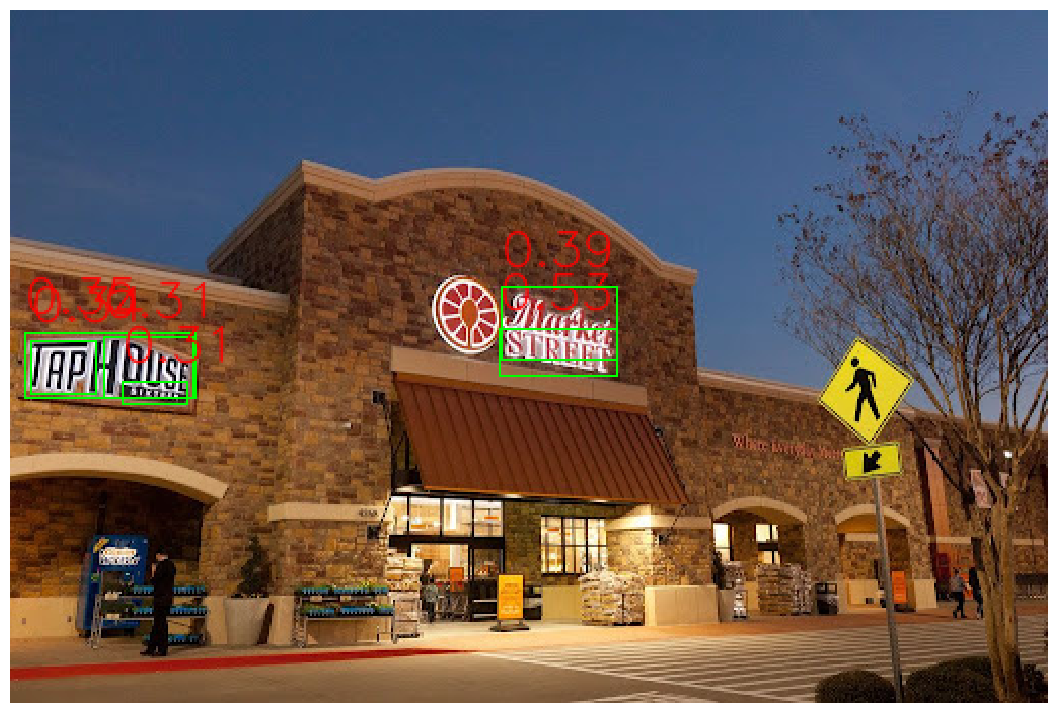

In [27]:
plt.figure(figsize=(15, 9))
plt.axis("off")
plt.imshow(convert_result_to_image(image, resized_image, boxes, conf_labels=True));